# Modelling with SFS

# Read Data

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_qc_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


## Extract data

In [2]:
X = dataDf.drop(['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'onetwenty_day_mortality'], axis = 1)
y_seven_day = dataDf['seven_day_mortality']

## Perform SFS

In [3]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

sfs = SequentialFeatureSelector(estimator = DecisionTreeClassifier(), n_features_to_select=10)
sfs.fit(X, y_seven_day)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                          n_features_to_select=10)

In [4]:
sfs.get_feature_names_out()

array(['Ambulatory Surgical Center', 'AMBULATORY OBSERVATION', 'ELECTIVE',
       'AMBULATORY SURGERY TRANSFER',
       'INTERNAL TRANSFER TO OR FROM PSYCH', 'WALK-IN/SELF REFERRAL',
       'visit_duration_hrs', 'gcs_motor_last', 'chloride_max',
       'sodium_last'], dtype=object)

## Obtained selected feature set

In [5]:
X_min = X[sfs.get_feature_names_out()]

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, X_min_train, X_min_test, y_seven_day_train, y_seven_day_test = train_test_split(X, X_min, y_seven_day, test_size=0.2, random_state=42)

In [27]:
X_train.shape, X_test.shape

((5681, 159), (1421, 159))

In [7]:
X_min_train.shape, X_min_test.shape

((5681, 10), (1421, 10))

In [8]:
y_seven_day_train.shape, y_seven_day_test.shape

((5681,), (1421,))

## Function to plot confusion matrix

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.title(title)
    plt.show()

## XGBoost classifier

In [11]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

[09:21:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
xgb_min = XGBClassifier()
xgb_min.fit(X_min_train, y_seven_day_train)
xgb_min_pred = xgb_min.predict(X_min_test)
xgb_min_prob = xgb_min.predict_proba(X_min_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:24:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
xgb = XGBClassifier()
xgb.fit(X_train, y_seven_day_train)
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

[09:26:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Confusion matrix

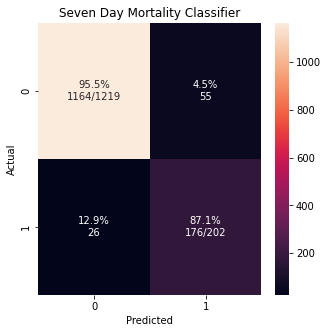

In [12]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

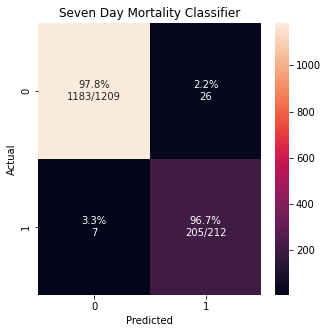

In [30]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

In [32]:
lr_min = LogisticRegression(fit_intercept=True, max_iter=500)
lr_min.fit(X_min_train, y_seven_day_train)
lr_min_pred = lr_min.predict(X_min_test)
lr_min_prob = lr_min.predict_proba(X_min_test)

In [33]:
lr = LogisticRegression(fit_intercept=True, max_iter=500)
lr.fit(X_train, y_seven_day_train)
lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)

### Confusion matrix

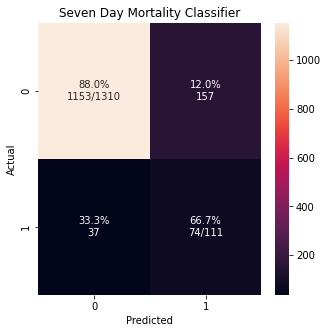

In [34]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lr_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

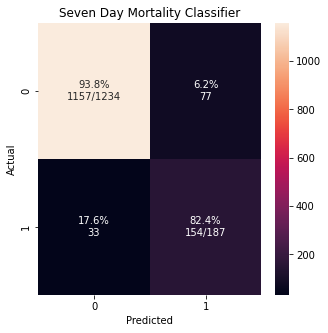

In [35]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lr_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

## LGBM

In [37]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt

In [38]:
lgbm_min = LGBMClassifier()
lgbm_min.fit(X_min_train, y_seven_day_train)
lgbm_min_pred = lgbm_min.predict(X_min_test)
lgbm_min_prob = lgbm_min.predict_proba(X_min_test)

In [39]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_seven_day_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_prob = lgbm.predict_proba(X_test)

### Confusion matrix

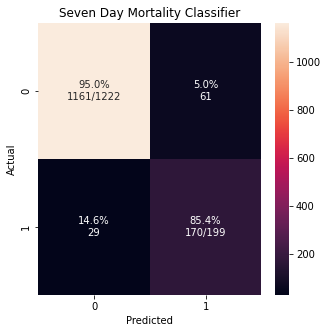

In [40]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lgbm_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

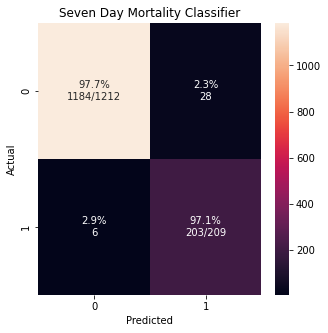

In [41]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(lgbm_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

### MLP

In [42]:
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt

In [43]:
mlp_min = MLPClassifier(random_state=1, max_iter=300)
mlp_min.fit(X_min_train, y_seven_day_train)
mlp_min_pred = mlp_min.predict(X_min_test)
mlp_min_prob = mlp_min.predict_proba(X_min_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_seven_day_train)
mlp_pred = mlp.predict(X_test)
mlp_prob = mlp.predict_proba(X_test)

### Confusion matrix

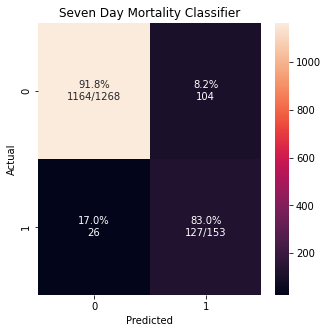

In [45]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(mlp_min_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

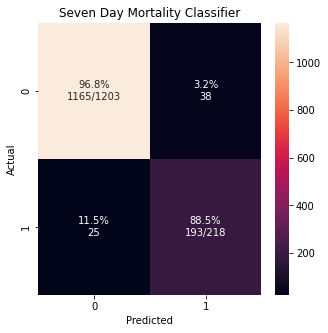

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(mlp_pred, y_seven_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

### AUROC

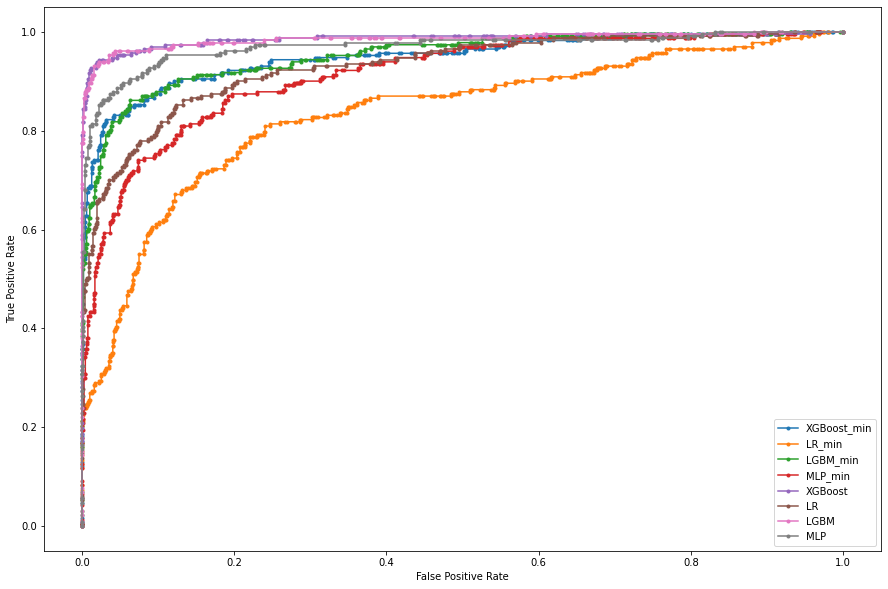

In [48]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for (test, prob, label) in [
        (y_seven_day_test, xgb_min_prob, 'XGBoost_min')
        , (y_seven_day_test, lr_min_prob, 'LR_min')
        , (y_seven_day_test, lgbm_min_prob, 'LGBM_min')
        , (y_seven_day_test, mlp_min_prob, 'MLP_min')
        , (y_seven_day_test, xgb_prob, 'XGBoost')
        , (y_seven_day_test, lr_prob, 'LR')
        , (y_seven_day_test, lgbm_prob, 'LGBM')
        , (y_seven_day_test, mlp_prob, 'MLP')
    ]:
    fpr, tpr, _ = roc_curve(test, [p2 for p1, p2 in prob])
    plt.plot(fpr, tpr, marker='.', label=label)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Performance metrics

In [49]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

data = []
data.append(["XGB", accuracy_score(xgb_pred, y_seven_day_test), f1_score(xgb_pred, y_seven_day_test), matthews_corrcoef(xgb_pred, y_seven_day_test), roc_auc_score(xgb_pred, y_seven_day_test)])
data.append(["LR", accuracy_score(lr_pred, y_seven_day_test), f1_score(lr_pred, y_seven_day_test), matthews_corrcoef(lr_pred, y_seven_day_test), roc_auc_score(lr_pred, y_seven_day_test)])
data.append(["LGBM", accuracy_score(lgbm_pred, y_seven_day_test), f1_score(lgbm_pred, y_seven_day_test), matthews_corrcoef(lgbm_pred, y_seven_day_test), roc_auc_score(lgbm_pred, y_seven_day_test)])
data.append(["MLP", accuracy_score(mlp_pred, y_seven_day_test), f1_score(mlp_pred, y_seven_day_test), matthews_corrcoef(mlp_pred, y_seven_day_test), roc_auc_score(mlp_pred, y_seven_day_test)])
data.append(["XGB_MIN", accuracy_score(xgb_min_pred, y_seven_day_test), f1_score(xgb_min_pred, y_seven_day_test), matthews_corrcoef(xgb_min_pred, y_seven_day_test), roc_auc_score(xgb_min_pred, y_seven_day_test)])
data.append(["LR_MIN", accuracy_score(lr_min_pred, y_seven_day_test), f1_score(lr_min_pred, y_seven_day_test), matthews_corrcoef(lr_min_pred, y_seven_day_test), roc_auc_score(lr_min_pred, y_seven_day_test)])
data.append(["LGBM_MIN", accuracy_score(lgbm_min_pred, y_seven_day_test), f1_score(lgbm_min_pred, y_seven_day_test), matthews_corrcoef(lgbm_min_pred, y_seven_day_test), roc_auc_score(lgbm_min_pred, y_seven_day_test)])
data.append(["MLP_MIN", accuracy_score(mlp_min_pred, y_seven_day_test), f1_score(mlp_min_pred, y_seven_day_test), matthews_corrcoef(mlp_min_pred, y_seven_day_test), roc_auc_score(mlp_min_pred, y_seven_day_test)])

perfromanceDf = pd.DataFrame(data, columns=["Label", "Accuracy", "F1", "MCC", "ROC"])
perfromanceDf

,Label,Accuracy,F1,MCC,ROC
0,XGB,0.976777,0.925508,0.912961,0.972738
1,LR,0.922590,0.736842,0.697362,0.880565
2,LGBM,0.976073,0.922727,0.910207,0.974095
3,MLP,0.955665,0.859688,0.833881,0.926867
4,XGB_MIN,0.942998,0.812933,0.781928,0.913084
5,LR_MIN,0.863476,0.432749,0.397705,0.773410
6,LGBM_MIN,0.936664,0.790698,0.756536,0.902177
7,MLP_MIN,0.908515,0.661458,0.628426,0.874023
